# StyleCLIP

Редактирование изображений -- очень важная и интересная задача в мире генеративных моделей. В этом ноутбуке мы с вами попробуем решить эту задачу на основе работы [StyleCLIP](https://arxiv.org/abs/2103.17249).

Данный метод позволяет редактировать изображения, сгенерированные [StyleGAN2](https://github.com/rosinality/stylegan2-pytorch), используя текстовые описания. Например, вы можете взять фотографию человека и с помощью текстовой подсказки "сделать волосы кудрявыми" изменить прическу на фотографии. Основная идея данной работы в том, чтобы "подвинуть" изначальный латент так, чтобы сгенерированное из него изображение лучше соответствовало предложенному промпту. Авторы предлагают два основных подхода:

- Оптимизация латентного вектора на основе CLIP Loss

- Обучение специального Mapper для сдвига

Более подробно про эти два подхода можно почитать в самой стате [StyleCLIP](https://arxiv.org/abs/2103.17249).

Мы с вами рассмотрим только одну часть предложенного метода, а именно оптимизацию для редактирования. Как уже было сказано, StyleCLIP оптимизирует латентный вектор [StyleGAN2](https://arxiv.org/abs/1912.04958) для более точного соотвествия заданному промпту.

Идея StyleCLIP с оптимизацией отображена на изображении ниже.




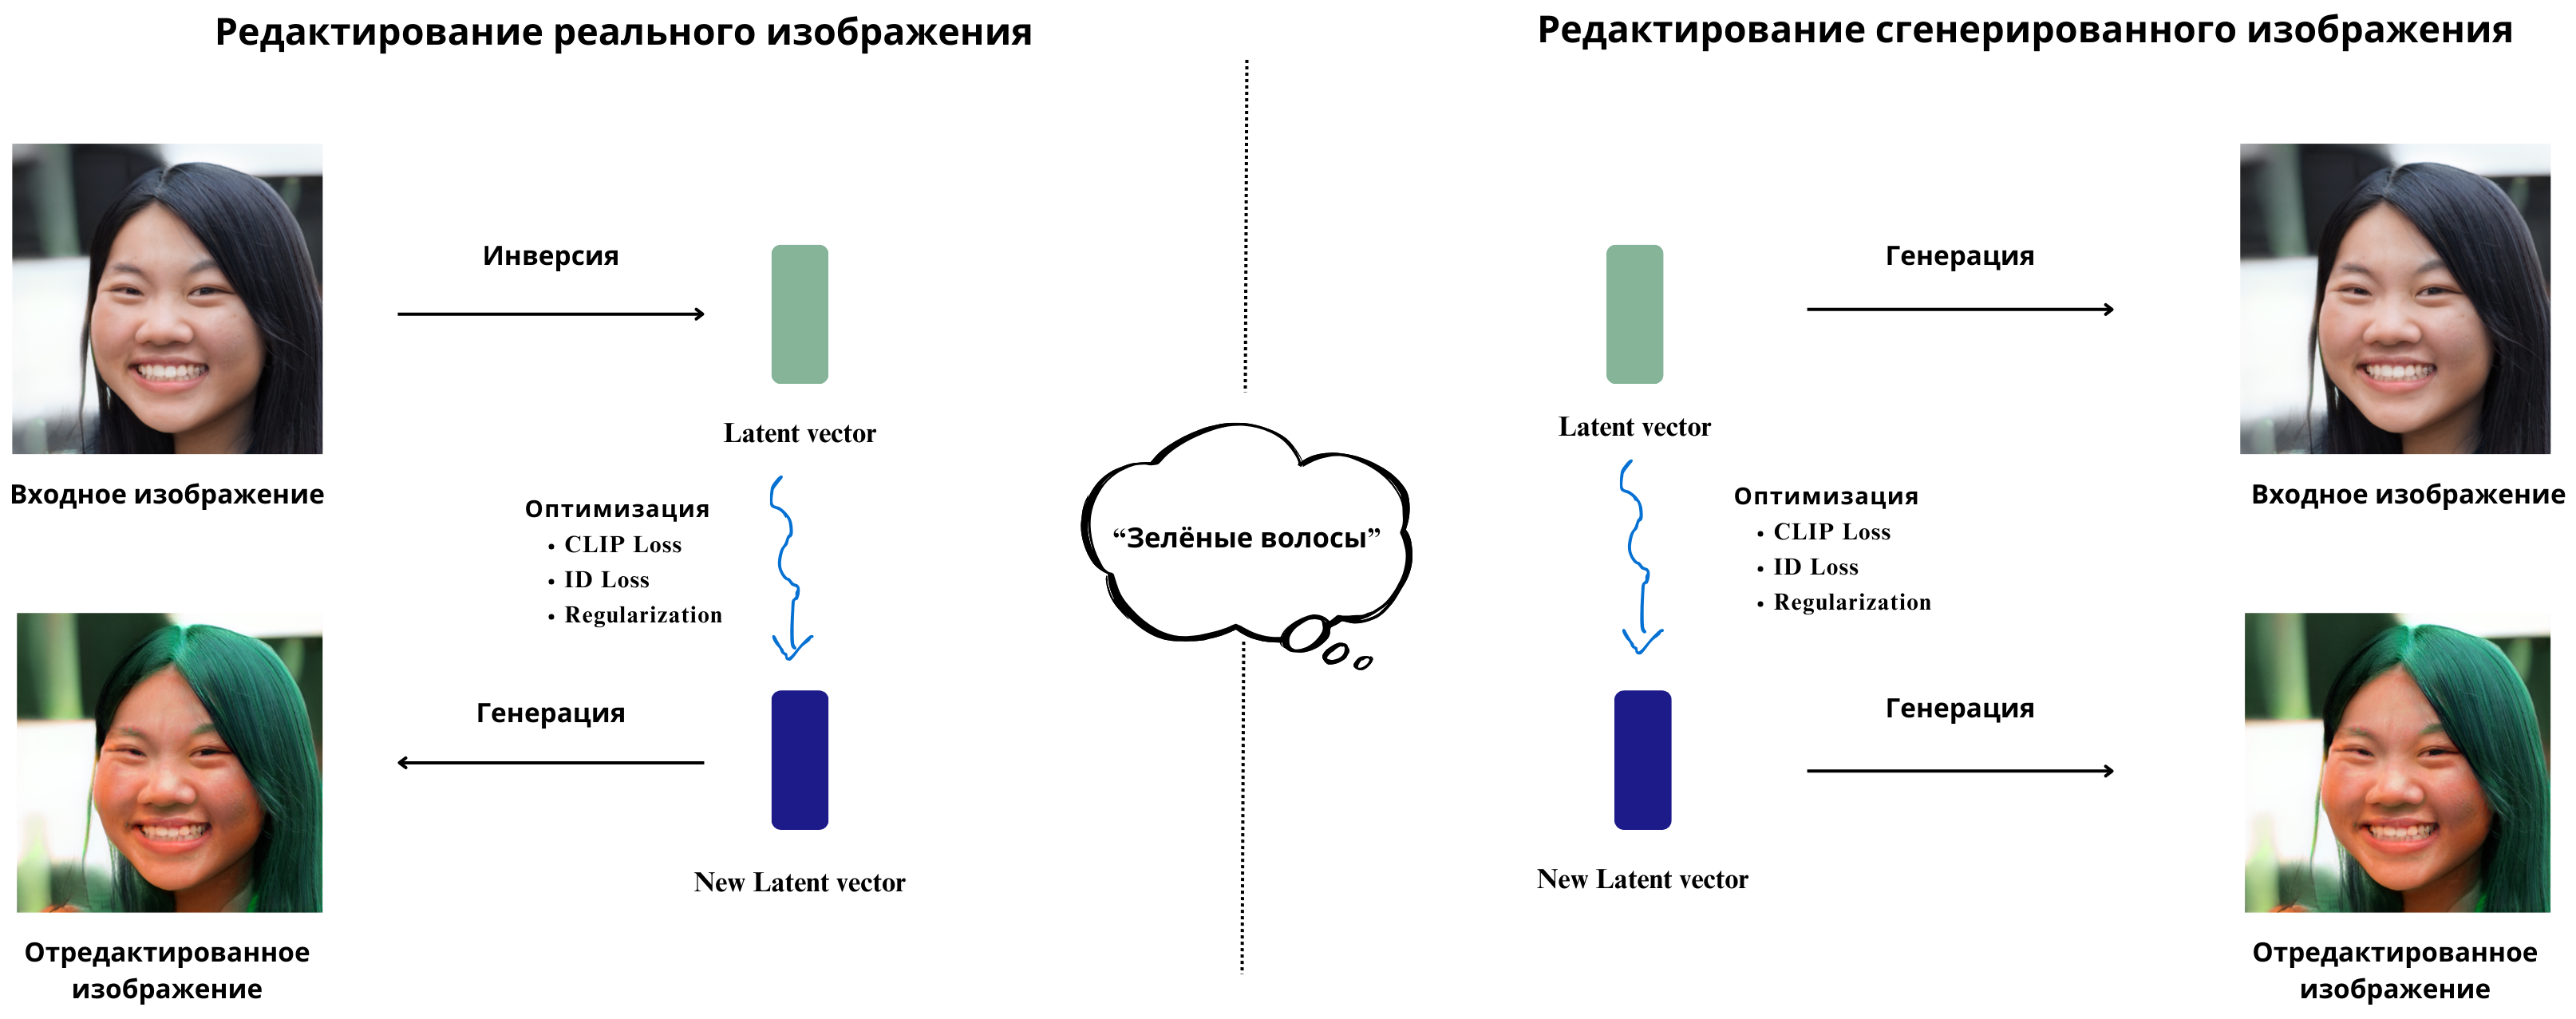

Наш план будет состоять в следующем:

1. Подготовка всех моделей для оптимизации

2. Реализация всех необходимых функций потерь:

  - CLIP Loss (1 балла)
  - ID Loss (1 балла)

3. Подготовка кода оптимизации (2 балла)

4. Выводы из полученных результатов (1 балл)

Давайте же попробуем написать код для этой оптимизации!

## Установка необходимых библиотек и подготовка окружения
Начнем с установки необходимых библиотек и клонирования репозитория StyleCLIP, чтобы использовать его методы.

In [1]:
# Установка необходимых библиотек

# Установка зависимостей
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# Установка дополнительных библиотек
!pip install Ninja

# Импорт нужных библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-uea36plc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-uea36plc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Клонирование репозитория StyleGAN2
!git clone https://github.com/rosinality/stylegan2-pytorch.git

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [3]:
cd stylegan2-pytorch/

/content/stylegan2-pytorch


In [4]:
# Будем работать с конкретным сидом
torch.manual_seed(345)

## Основная идея статьи


Как уже было сказано, мы хотим редактировать изображение с помощью текста. Для этого будем использовать [CLIP](https://paperswithcode.com/method/clip) модель для некоторого гайданса в процессе оптимизации.

Задачу мы хотим построить следующим образом: имея исходный латентный вектор $w \in W$ мы хотим оптимизировать его под текстовый запрос $t$. Давайте подгрузм нашу модель и сгенерируем картинку для дальнейшей оптимизации.

Для работы со StyleGAN-2 нам для начала нужно скачать модель. Для скачивания мы используем следующий код:

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [6]:
# Зададим девайс: cuda или cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Зададим сид
seed = 3456
torch.manual_seed(seed)

# Загрузка модели генератора StyleGAN2
from model import Generator
latent_dim = 512
generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)
state_dict = torch.load('/content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt', map_location=device)
generator.load_state_dict(state_dict['g_ema'])
generator.eval()

print("Генератор StyleGAN2 загружены.")


/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Генератор StyleGAN2 загружены.


### Функция для генерации изображения из латентного вектора
Эта функция генерирует изображение из латентного вектора $z \in Z$ ($w \in W$), что нам пригодится для визуализации процесса редактирования.

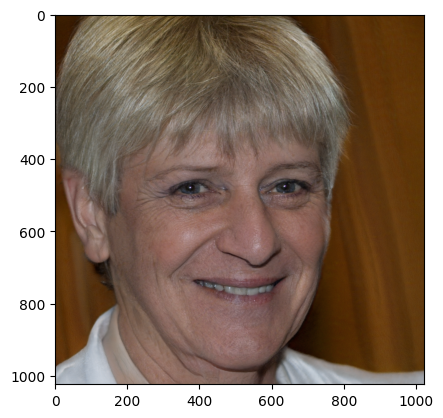

In [39]:
# Сгенерируем изображение
latent_z = torch.randn(10000, 512, device=device) # Z noise
latent_z_generated = latent_z.mean(0, keepdim=True)

with torch.no_grad():
  target_img, _ = generator([latent_z_generated], input_is_latent=False)
  plt.imshow((target_img.permute(0, 2, 3, 1)[0].cpu().numpy()+1)/2)

## Задача оптимизации

Теперь давайте подронее сформулируем задачу оптимизации.

Нам необходимо следующее:

- Отредактированное изображение соответствует текстовому запросу

- Сохраняет identity изначального человека.

Авторы предлагают следующий лосс для оптимизации:

$$\arg \min_{w \in W} D_{\text{CLIP}}(G(w), t) + \lambda_2 \|w - w_s\|_2 + \lambda_{\text{ID}} L_{\text{ID}}(w)
$$

Давайте разберёмся с каждой частью подробнее.

### CLIP loss

Начнём мы с CLIP loss.

 $D_{\text{CLIP}}$ — косинусное расстояние между эмбеддингами [CLIP](https://habr.com/ru/articles/539312/) для двух аргументов.

$$D_{\text{CLIP}}(G(w), t) = 1 - \frac{\langle E_{\text{CLIP}}(G(w)) \cdot E_{\text{CLIP}}(t) \rangle }{\|E_{\text{CLIP}}(G(w))\| \cdot \|E_{\text{CLIP}}(t)\|}$$


In [18]:
import torch
import clip


class CLIPLoss(torch.nn.Module):
    """
    Этот класс определяет пользовательскую функцию потерь на основе CLIP (Contrastive Language–Image Pre-training).
    Он измеряет сходство между изображением и текстовым описанием.
    """

    def __init__(self, stylegan_size=1024):
        """
        Инициализирует класс CLIPLoss.

        Args:
            opts: Объект, содержащий различные параметры, включая размер изображения StyleGAN.
        """
        super(CLIPLoss, self).__init__()
        # Загружаем предварительно обученную модель CLIP и функцию предварительной обработки
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")

        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=stylegan_size // 32)

    def forward(self, image, text):
        """
        Вычисляет потери CLIP между изображением и текстом.

        Args:
            image: Входной тензор изображения (B, C, H, W) с нормализацией [-1, 1].
            text: Список строк длиной B.

        Returns:
            Значение потерь CLIP (меньше — лучше соответствие).
        """
        # Приводим изображения в диапазон [0, 1] и меняем размер
        image = (image + 1) / 2  # из [-1, 1] → [0, 1]
        image = self.avg_pool(self.upsample(image))

        # Вычисляем эмбеддинги
        image_features = self.model.encode_image(image)
        text_tokens = clip.tokenize(text).to(image.device)
        text_features = self.model.encode_text(text_tokens)

        # Нормируем эмбеддинги
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Косинусное сходство
        similarity = torch.sum(image_features * text_features, dim=-1)

        # Потери: 1 - cos similarity
        loss = 1 - similarity.mean()

        return loss


In [19]:
clip_loss = CLIPLoss()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 141MiB/s]


### ID loss

Для сохранения identity человека использует специально предобученную модель [ArcFace](https://arxiv.org/abs/1801.07698), которая по фотографии вычисляет некоторые характерные для человека embedding вектора. Затем нам необходимо посчитать косинусное расстояние между ожидаемым embedding вектором и тем, что получается в процессе оптимизации:

$$ L_{\text{ID}}(w) = 1 - \langle R(G(w_s)), R(G(w)) \rangle $$

Обратите внимание, что здесь не используется дополнительная нормировка


Давайте подгрузим нашу модель и реализуем желаемую функцию потерь.


### Подгрузка модели

Далее у нас будет подгрузка самой модели, позаимствованная из репозитория [StyleCLIP](https://github.com/orpatashnik/StyleCLIP/blob/main/models/facial_recognition/helpers.py). Вы можете более подробно ознакомиться с кодом этой модели ниже, но мы не будем заострять на ней внимание.


In [20]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Dropout, Sequential, Module

"""
Modified Backbone implementation from [TreB1eN](https://github.com/TreB1eN/InsightFace_Pytorch)
"""
from collections import namedtuple
import torch
from torch.nn import Conv2d, BatchNorm2d, PReLU, ReLU, Sigmoid, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module

"""
ArcFace implementation from [TreB1eN](https://github.com/TreB1eN/InsightFace_Pytorch)
"""


class Flatten(Module):
	def forward(self, input):
		return input.view(input.size(0), -1)


def l2_norm(input, axis=1):
	norm = torch.norm(input, 2, axis, True)
	output = torch.div(input, norm)
	return output


class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
	""" A named tuple describing a ResNet block. """


def get_block(in_channel, depth, num_units, stride=2):
	return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
	if num_layers == 50:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=4),
			get_block(in_channel=128, depth=256, num_units=14),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 100:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=13),
			get_block(in_channel=128, depth=256, num_units=30),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 152:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=8),
			get_block(in_channel=128, depth=256, num_units=36),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	else:
		raise ValueError("Invalid number of layers: {}. Must be one of [50, 100, 152]".format(num_layers))
	return blocks


class SEModule(Module):
	def __init__(self, channels, reduction):
		super(SEModule, self).__init__()
		self.avg_pool = AdaptiveAvgPool2d(1)
		self.fc1 = Conv2d(channels, channels // reduction, kernel_size=1, padding=0, bias=False)
		self.relu = ReLU(inplace=True)
		self.fc2 = Conv2d(channels // reduction, channels, kernel_size=1, padding=0, bias=False)
		self.sigmoid = Sigmoid()

	def forward(self, x):
		module_input = x
		x = self.avg_pool(x)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return module_input * x


class bottleneck_IR(Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = MaxPool2d(1, stride)
		else:
			self.shortcut_layer = Sequential(
				Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				BatchNorm2d(depth)
			)
		self.res_layer = Sequential(
			BatchNorm2d(in_channel),
			Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), PReLU(depth),
			Conv2d(depth, depth, (3, 3), stride, 1, bias=False), BatchNorm2d(depth)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class bottleneck_IR_SE(Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR_SE, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = MaxPool2d(1, stride)
		else:
			self.shortcut_layer = Sequential(
				Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				BatchNorm2d(depth)
			)
		self.res_layer = Sequential(
			BatchNorm2d(in_channel),
			Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
			PReLU(depth),
			Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
			BatchNorm2d(depth),
			SEModule(depth, 16)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class Backbone(Module):
	def __init__(self, input_size, num_layers, mode='ir', drop_ratio=0.4, affine=True):
		super(Backbone, self).__init__()
		assert input_size in [112, 224], "input_size should be 112 or 224"
		assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
		assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
		blocks = get_blocks(num_layers)
		if mode == 'ir':
			unit_module = bottleneck_IR
		elif mode == 'ir_se':
			unit_module = bottleneck_IR_SE
		self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1, bias=False),
									  BatchNorm2d(64),
									  PReLU(64))
		if input_size == 112:
			self.output_layer = Sequential(BatchNorm2d(512),
			                               Dropout(drop_ratio),
			                               Flatten(),
			                               Linear(512 * 7 * 7, 512),
			                               BatchNorm1d(512, affine=affine))
		else:
			self.output_layer = Sequential(BatchNorm2d(512),
			                               Dropout(drop_ratio),
			                               Flatten(),
			                               Linear(512 * 14 * 14, 512),
			                               BatchNorm1d(512, affine=affine))

		modules = []
		for block in blocks:
			for bottleneck in block:
				modules.append(unit_module(bottleneck.in_channel,
										   bottleneck.depth,
										   bottleneck.stride))
		self.body = Sequential(*modules)

	def forward(self, x):
		x = self.input_layer(x)
		x = self.body(x)
		x = self.output_layer(x)
		return l2_norm(x)


def IR_50(input_size):
	"""Constructs a ir-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_101(input_size):
	"""Constructs a ir-101 model."""
	model = Backbone(input_size, num_layers=100, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_152(input_size):
	"""Constructs a ir-152 model."""
	model = Backbone(input_size, num_layers=152, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_SE_50(input_size):
	"""Constructs a ir_se-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir_se', drop_ratio=0.4, affine=False)
	return model


def IR_SE_101(input_size):
	"""Constructs a ir_se-101 model."""
	model = Backbone(input_size, num_layers=100, mode='ir_se', drop_ratio=0.4, affine=False)
	return model


def IR_SE_152(input_size):
	"""Constructs a ir_se-152 model."""
	model = Backbone(input_size, num_layers=152, mode='ir_se', drop_ratio=0.4, affine=False)
	return model

### ID loss

Теперь непосредственно реализуем нашу функцию потерь.

In [21]:
import torch
from torch import nn


class IDLoss(nn.Module):
    def __init__(self, model_weights, device='cuda'):
        super(IDLoss, self).__init__()
        print('Loading ResNet ArcFace')
        # Загружаем предобученную модель ResNet ArcFace для извлечения признаков лица.
        # input_size: размер входного изображения (112x112).
        self.facenet = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
        # Загружаем веса предобученной модели
        self.facenet.load_state_dict(torch.load(model_weights))
        self.pool = torch.nn.AdaptiveAvgPool2d((256, 256))
        self.face_pool = torch.nn.AdaptiveAvgPool2d((112, 112))
        self.facenet.eval()
        # Перемещаем модель ArcFace на GPU, если доступен.
        self.facenet.to(device)


    def extract_feats(self, x):
        # Функция для извлечения эмбеддингов лица из изображения x.
        # Если размер изображения не 256x256, изменяем его с помощью пулинга.
        if x.shape[2] != 256:
            x = self.pool(x)
        # Обрезаем центральную область изображения (35:223, 32:220), содержащую лицо.
        x = x[:, :, 35:223, 32:220]
        # Изменяем размер обрезанной области до 112x112 с помощью пулинга.
        x = self.face_pool(x)
        # Извлекаем эмбеддинги лица с помощью модели ArcFace.
        x_feats = self.facenet(x)
        # Возвращаем извлеченные эмбеддинги.
        return x_feats

    def forward(self, y_hat, y):
        # Функция для вычисления ID Loss.
        # y_hat: отредактированное изображение.
        # y: исходное изображение.
        n_samples = y.shape[0]

        # Извлекаем признаки лица
        y_feats = self.extract_feats(y).detach()       # исходное
        y_hat_feats = self.extract_feats(y_hat)        # сгенерированное

        # Косинусная дистанция (1 - cos_sim) между эмбеддингами
        loss = 0
        for i in range(n_samples):
            sim = torch.nn.functional.cosine_similarity(
                y_hat_feats[i].unsqueeze(0), y_feats[i].unsqueeze(0)
            )
            loss += 1 - sim

        return loss / n_samples

In [22]:
# Загрузим нашу модель ArcFace
model_path = "/content/stylegan2-pytorch/model_ir_se50.pth"
id_loss = IDLoss(model_path, device)

Loading ResNet ArcFace


## Инициализация латентного вектора и текстовой подсказки
Определим латентный вектор
𝑊
W для исходного изображения и преобразуем текстовую подсказку в вектор с помощью CLIP, что будет служить нашей целью для редактирования.

## Оптимизация для редактирования изображения
Реализуем оптимизацию, используя Adam. На каждом шаге обновляется латентный вектор $w \in W$ для минимизации потерь CLIP, пока результат не будет похож на текстовую подсказку.

Основной псевдокод оптимизации представлен ниже:

```python

for step in range(num_steps):  # <----------- итерируемся по датасету несколько раз
    torch.cuda.empty_cache() # <------------- очищаем кэш модели
    optimizer.zero_grad()  # <------------- обуляем градиенты модели
    image, _ = generator([latent], input_is_latent=True, randomize_noise=False)  # <------------- получаем картинку из StyleGAN-2
    loss = clip_loss + l2_lambda * l2_loss + id_lambda * id_loss
    loss.backward()  # <------------------- считаем градиенты
    optimizer.step()  # <------------------ делаем шаг градиентного спуска
    if convergence:  # <------------------- в случае сходимости выходим из цикла
        break
```

Где полная функция потерь считается по формуле:
$$\arg \min_{w \in W} D_{\text{CLIP}}(G(w), t) + \lambda_2 \|w - w_s\|_2 + \lambda_{\text{ID}} L_{\text{ID}}(w)
$$

Дополнительно сохраните значения лосс функций для дальнейшей визуализации.


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



num_steps = 300
lr = 0.05
l2_lambda = 0.008
id_lambda = 0.1
text_prompt = ["a person with green hair"]

# Инициализация латентного вектора
w = generator.style(latent_z_generated)  # Преобразуем z → w
latent = w.clone().detach().requires_grad_(True)

optimizer = torch.optim.Adam([latent], lr=lr)

loss_values = []
clip_loss_values = []
id_loss_values = []

for step in range(num_steps):
    torch.cuda.empty_cache()
    optimizer.zero_grad()

    # Генерация изображения
    generated_image, _ = generator([latent], input_is_latent=True, randomize_noise=False)

    # Расчёт всех потерь
    loss_clip = clip_loss(generated_image, text_prompt)
    loss_l2 = F.mse_loss(latent, w)
    loss_id = id_loss(generated_image, target_img)

    loss = loss_clip + l2_lambda * loss_l2 + id_lambda * loss_id

    loss.backward(retain_graph=True)
    optimizer.step()

    loss_values.append(loss.item())
    clip_loss_values.append(loss_clip.item())
    id_loss_values.append(loss_id.item())


    if step % 20 == 0:
        print(f"Step {step}/{num_steps} - Loss: {loss.item():.4f} - CLIP: {loss_clip.item():.4f} - ID: {loss_id.item():.4f}")

# Визуализация финального изображения
with torch.no_grad():
    final_img, _ = generator([latent], input_is_latent=True, randomize_noise=False)
    final_img = (final_img.clamp(-1, 1) + 1) / 2
    plt.imshow(final_img[0].permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("Edited Image")


Step 0/300 - Loss: 0.7942 - CLIP: 0.7900 - ID: 0.0415
Step 20/300 - Loss: 0.6588 - CLIP: 0.6416 - ID: 0.1684
Step 40/300 - Loss: 0.6356 - CLIP: 0.6230 - ID: 0.1190
Step 60/300 - Loss: 0.6200 - CLIP: 0.6094 - ID: 0.0974
Step 80/300 - Loss: 0.6077 - CLIP: 0.5957 - ID: 0.1083
Step 100/300 - Loss: 0.5948 - CLIP: 0.5835 - ID: 0.0991
Step 120/300 - Loss: 0.5871 - CLIP: 0.5742 - ID: 0.1115
Step 140/300 - Loss: 0.5874 - CLIP: 0.5693 - ID: 0.1592
Step 160/300 - Loss: 0.5672 - CLIP: 0.5542 - ID: 0.1043
Step 180/300 - Loss: 0.5568 - CLIP: 0.5449 - ID: 0.0921
Step 200/300 - Loss: 0.5505 - CLIP: 0.5396 - ID: 0.0814
Step 220/300 - Loss: 0.5498 - CLIP: 0.5391 - ID: 0.0781
Step 240/300 - Loss: 0.5446 - CLIP: 0.5342 - ID: 0.0744
Step 260/300 - Loss: 0.5420 - CLIP: 0.5322 - ID: 0.0673
Step 280/300 - Loss: 0.5424 - CLIP: 0.5322 - ID: 0.0701


Визуализируйте лоссы в зависимости от step

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Total Loss')
plt.plot(clip_loss_values, label='CLIP Loss')
plt.plot(id_loss_values, label='ID Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. Step')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'loss_values' is not defined

<Figure size 1000x600 with 0 Axes>

Сохряним результаты!

In [ ]:
import os

filename = prompt

# Save the latents to a .pt file.
latent_path = os.path.join(save_dir, filename + ".pt")
torch.save(latent, latent_path)

# Save the image to a .png file.
image_path = os.path.join(save_dir, filename + ".png")
save_image(img_gen, image_path)


print(f"Ваше изображение и латенты успешно сохранены в папке {save_dir}")

Ваше изображение и латенты успешно сохранены в results


### Вывооды

Напишите ваши выводы, что получилось, что нет, почему получилось, почему нет.